# Recursive Feature Elimination(RFE)

**递归特征消除**：
反复构建模型，每次迭代移除最不重要的特征，直到达到所需的特征数量。


In [19]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
current_path = os.getcwd()

# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path))


In [ ]:
# Load data (assuming you have dft_train_X, dft_train_y)
file_dir = os.path.join(current_path, './Data')
# Load dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_train_set.csv'))
dft_all_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_all_train_y = dft_train['band_gap']
dft_all_train_X.shape, dft_all_train_y.shape

((7869, 228), (7869,))

In [21]:
# 从dft_train_X中抽取出一份验证集
mp_unique_comp = dft_train['composition'].unique()
len(mp_unique_comp)

7838

In [22]:
import random
# 从mp_unique_comp中随机采样组成
random.seed(RANDOM_SEED)
random_index = random.sample(range(len(mp_unique_comp)), round(dft_train.shape[0]*0.2))
mp_val_comp = mp_unique_comp[random_index]
dft_train_set = dft_train[~dft_train['composition'].isin(mp_val_comp)]
dft_val_set = dft_train[dft_train['composition'].isin(mp_val_comp)]
print(f'MP训练集大小：{len(dft_train_set)}')
print(f'MP验证集大小：{len(dft_val_set)}')

MP训练集大小：6292
MP验证集大小：1577


In [23]:
# Prepare data
dft_train_X = dft_train_set.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train_set['band_gap']
# 
dft_val_X = dft_val_set.drop(columns=['composition', 'band_gap'])
dft_val_y = dft_val_set['band_gap']

dft_train_X.shape, dft_train_y.shape, dft_val_X.shape, dft_val_y.shape

((6292, 228), (6292,), (1577, 228), (1577,))

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

In [31]:
# 为加快运行速度，自己实现RFE
def custom_rfe(model, X, y, X_val, y_val, target_features, step=1, verbose=True):
    """
    自定义递归特征消除函数
    """
    # 存储每一步rmse
    rmse_scores = []
    # 存储每一步选中的特征
    selected_features = []
    while X.shape[1] >= target_features:
        # 训练模型
        model.fit(X, y)
        
        # 获取特征重要性
        importances = model.feature_importances_
        
        # 获取特征索引
        feature_indices = np.argsort(importances)[::-1]
        # 
        selected_features.append(X.columns[feature_indices])
        
        # 在验证集上进行预测
        y_pred = model.predict(X_val)
        # 计算均方根误差 (RMSE)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
        # 打印进度
        if verbose:
            print(f"Feature nums: {X.shape[1]}, RMSE: {rmse:.4f}")

        # 删除最不重要的特征
        X = X.iloc[:, feature_indices[:-step]]
        X_val = X_val.iloc[:, feature_indices[:-step]]

    return selected_features, rmse_scores

# 使用自定义的 RFE 函数
model = RandomForestRegressor(
    n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.5, random_state=RANDOM_SEED, n_jobs=-1)
selected_features, rmse_scores = custom_rfe(model, dft_train_X, dft_train_y, dft_val_X, dft_val_y, target_features=1, step=1, verbose=True)

Feature nums: 228, RMSE: 0.5215
Feature nums: 227, RMSE: 0.5199
Feature nums: 226, RMSE: 0.5173
Feature nums: 225, RMSE: 0.5194
Feature nums: 224, RMSE: 0.5197
Feature nums: 223, RMSE: 0.5188
Feature nums: 222, RMSE: 0.5183
Feature nums: 221, RMSE: 0.5166
Feature nums: 220, RMSE: 0.5210
Feature nums: 219, RMSE: 0.5210
Feature nums: 218, RMSE: 0.5201
Feature nums: 217, RMSE: 0.5148
Feature nums: 216, RMSE: 0.5199
Feature nums: 215, RMSE: 0.5197
Feature nums: 214, RMSE: 0.5170
Feature nums: 213, RMSE: 0.5195
Feature nums: 212, RMSE: 0.5201
Feature nums: 211, RMSE: 0.5206
Feature nums: 210, RMSE: 0.5183
Feature nums: 209, RMSE: 0.5202
Feature nums: 208, RMSE: 0.5183
Feature nums: 207, RMSE: 0.5206
Feature nums: 206, RMSE: 0.5199
Feature nums: 205, RMSE: 0.5219
Feature nums: 204, RMSE: 0.5158
Feature nums: 203, RMSE: 0.5192
Feature nums: 202, RMSE: 0.5174
Feature nums: 201, RMSE: 0.5194
Feature nums: 200, RMSE: 0.5151
Feature nums: 199, RMSE: 0.5222
Feature nums: 198, RMSE: 0.5217
Feature 

In [45]:
rmse_scores = rmse_scores[::-1]
selected_features = selected_features[::-1]
rmse_scores

[np.float64(0.5214911211159918),
 np.float64(0.5199110543347213),
 np.float64(0.51726031436386),
 np.float64(0.5194487290708508),
 np.float64(0.5196689567774494),
 np.float64(0.5188146984343357),
 np.float64(0.518328478599555),
 np.float64(0.5165835300137985),
 np.float64(0.5209534384680694),
 np.float64(0.5210215851639689),
 np.float64(0.5200771466954405),
 np.float64(0.5148312215157579),
 np.float64(0.5199272900844807),
 np.float64(0.5196734784233179),
 np.float64(0.5169606585232445),
 np.float64(0.5194936451706229),
 np.float64(0.5201471919556278),
 np.float64(0.5206343072928244),
 np.float64(0.5182520763183802),
 np.float64(0.5201502022492622),
 np.float64(0.5182877454249553),
 np.float64(0.5205563259428233),
 np.float64(0.5198772969963258),
 np.float64(0.5218970560365266),
 np.float64(0.5158246832576256),
 np.float64(0.519195824835371),
 np.float64(0.5174148056367284),
 np.float64(0.5194194467486413),
 np.float64(0.5151240188216006),
 np.float64(0.5222483666142097),
 np.float64(0.

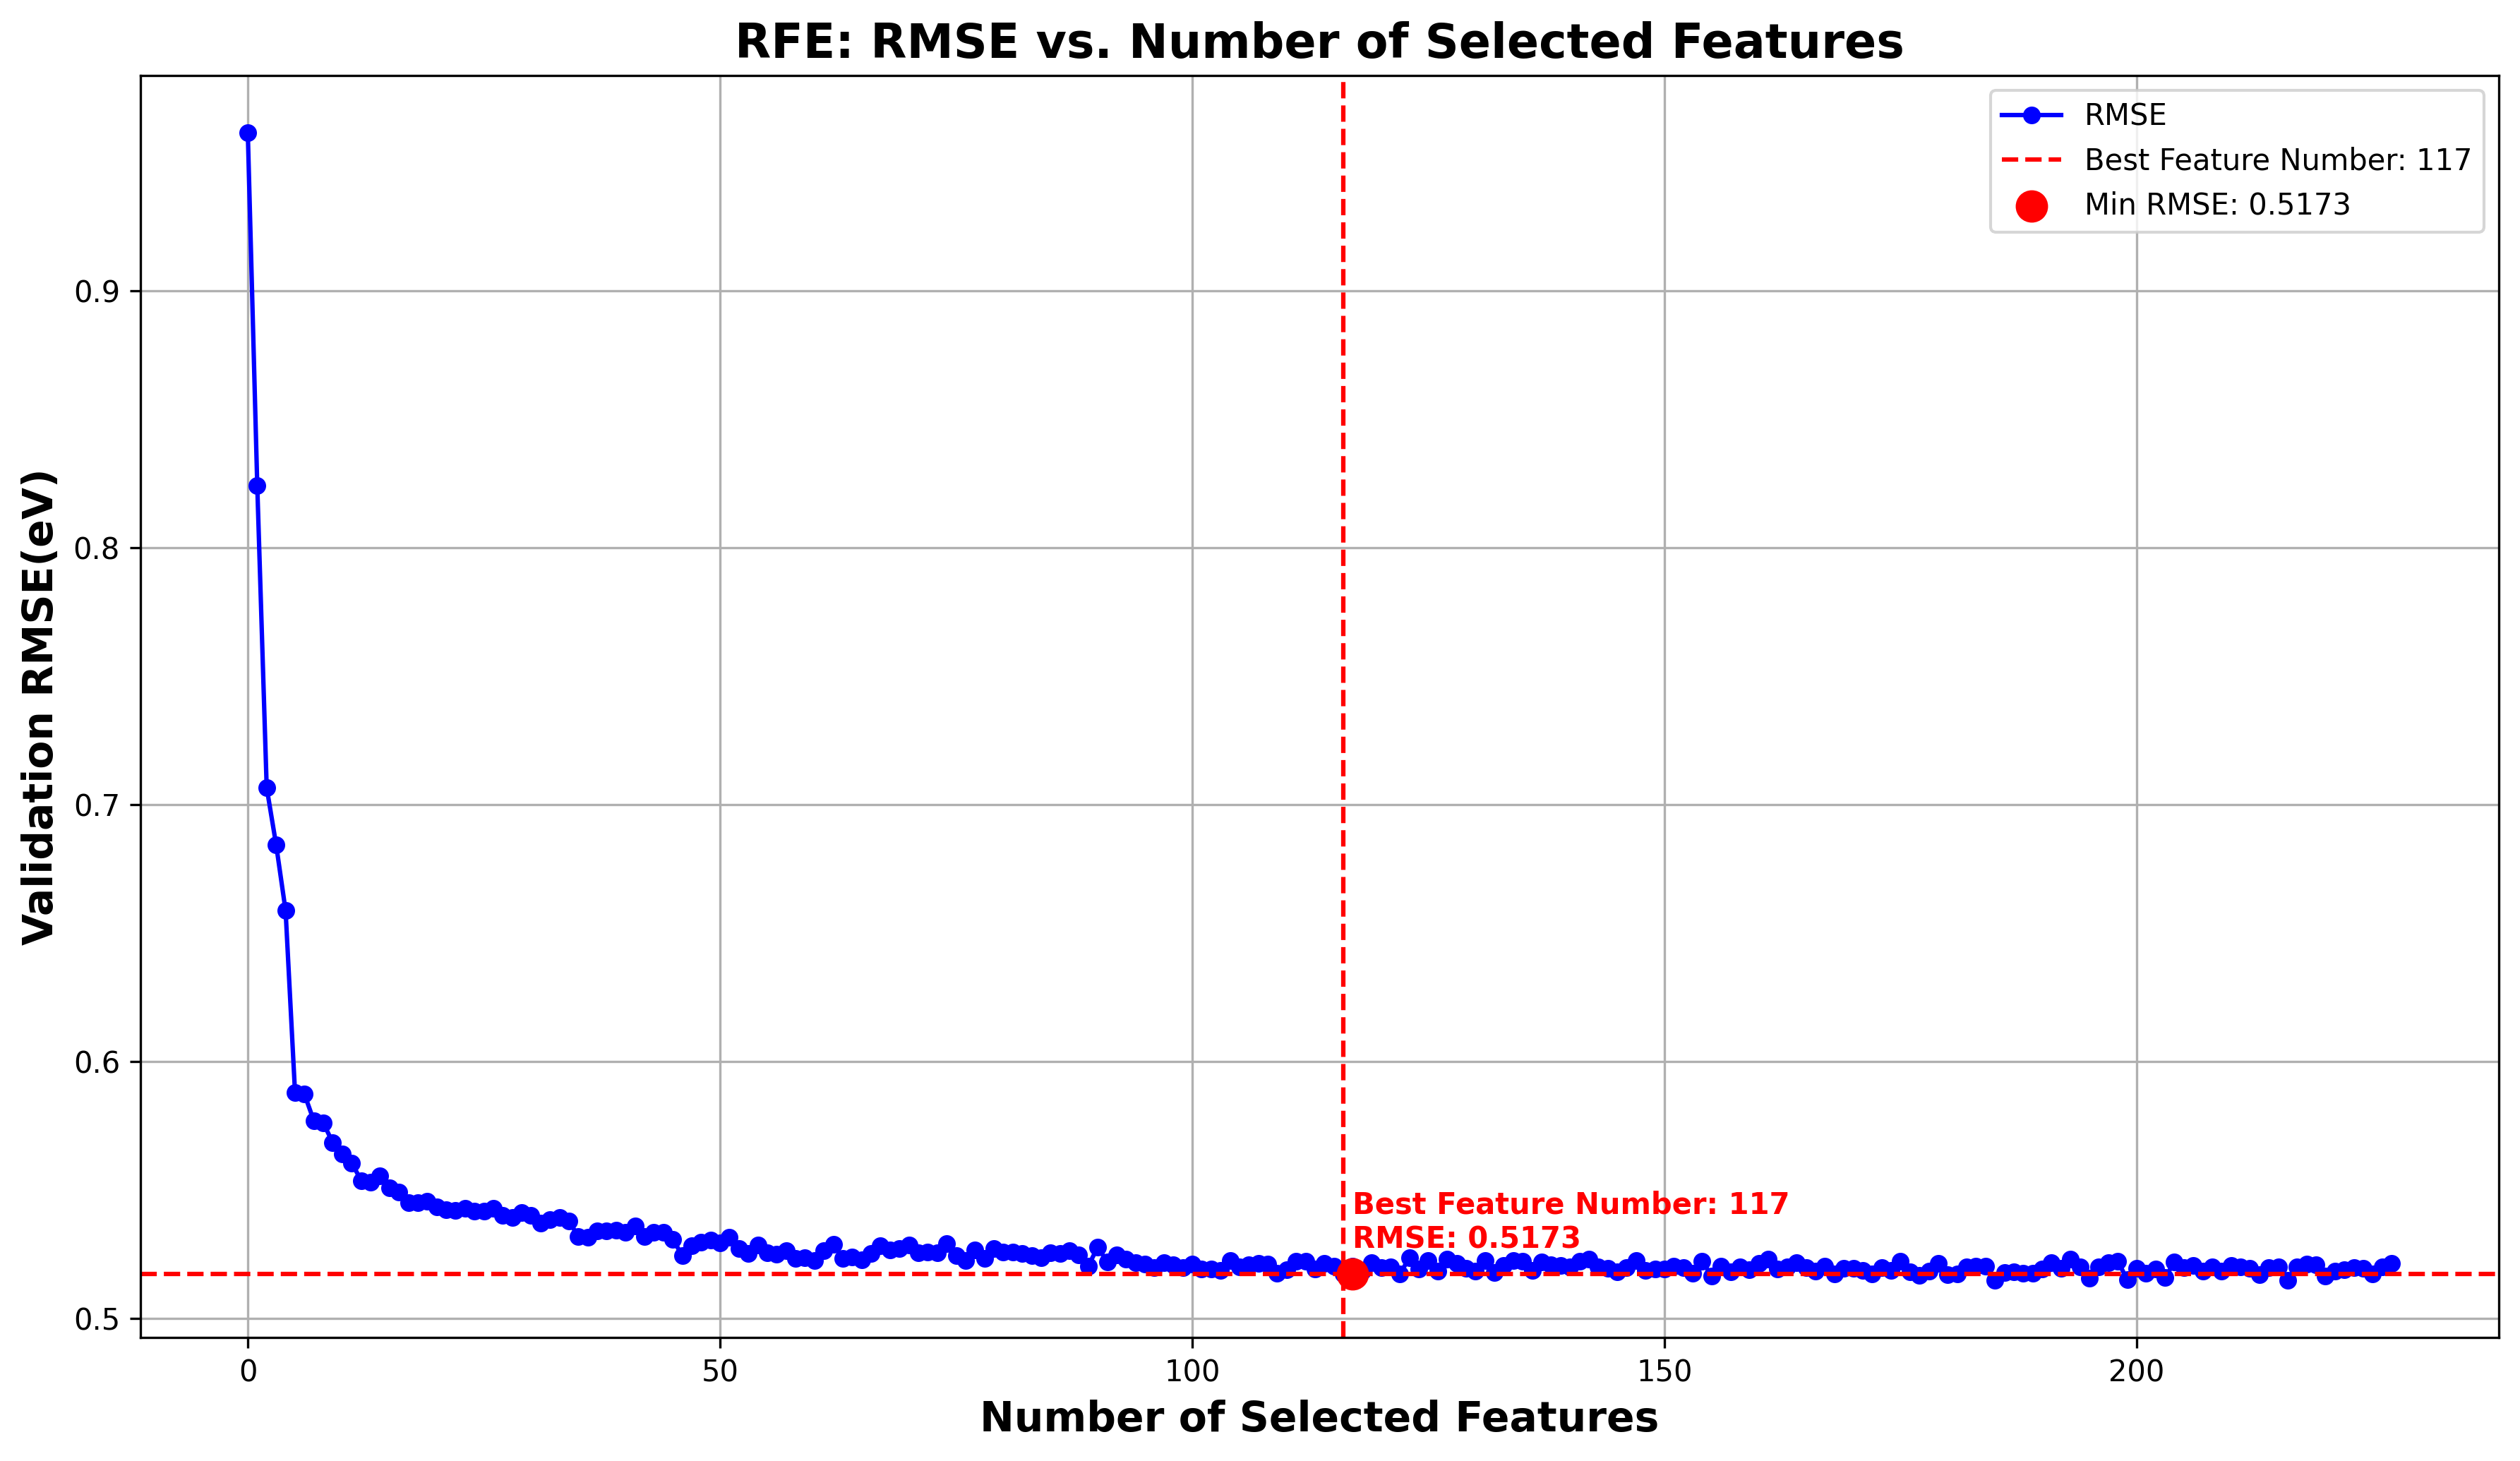


根据验证集 RMSE，最佳的特征数量是: 117
对应的最小验证集 RMSE 是: 0.5173


In [37]:
# --- 绘制 RMSE vs. 特征数量图 ---
plt.figure(figsize=(12, 7), dpi=300)
plt.plot(range(len(rmse_scores)), rmse_scores, marker='o', linestyle='-', color='blue', markersize=5, label='RMSE')
plt.xlabel('Number of Selected Features', fontsize=14, weight='bold')
plt.ylabel('Validation RMSE(eV)', fontsize=14, weight='bold')
plt.title('RFE: RMSE vs. Number of Selected Features', fontsize=16, weight='bold')
plt.grid(True)

# 在少于150个特征时找到 RMSE 最小的点
best_n_features_index = np.argmin(rmse_scores[:150])
best_n_features = best_n_features_index + 1  # +1 because index starts from 0
min_rmse = rmse_scores[best_n_features_index]

plt.axvline(x=best_n_features_index, color='red', linestyle='--', label=f'Best Feature Number: {best_n_features}')
plt.axhline(y=rmse_scores[best_n_features_index], color='red', linestyle='--')
plt.text(best_n_features_index + 1, rmse_scores[best_n_features_index] + 0.01,
         f'Best Feature Number: {best_n_features_index + 1}\nRMSE: {rmse_scores[best_n_features_index]:.4f}',
         fontsize=10, color='red', weight='bold')

plt.scatter(best_n_features, min_rmse, color='red', s=100, zorder=5,
            label=f'Min RMSE: {min_rmse:.4f}')
plt.legend(fontsize=10)
plt.tight_layout() # 调整布局防止标签重叠
fig_path = os.path.join(current_path, 'figures', 'feature_selection')
os.makedirs(fig_path, exist_ok=True)
plt.savefig(os.path.join(fig_path, 'RFE_feature_selection.png'), dpi=300)
plt.show()
print(f"\n根据验证集 RMSE，最佳的特征数量是: {best_n_features}")
print(f"对应的最小验证集 RMSE 是: {min_rmse:.4f}")

In [44]:
best_n_features

np.int64(117)

In [46]:
# 获取最佳特征集的名称
estimator_final = RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1)

# 使用最佳特征数量重新训练模型
best_features = selected_features[best_n_features - 1]  # 获取最佳特征
X_train_best = dft_all_train_X.loc[:, best_features]
estimator_final.fit(X_train_best, dft_all_train_y)
# 输出特征重要性
importances = estimator_final.feature_importances_
indices = np.argsort(importances)[::-1]
# 获取特征名称
feature_names = X_train_best.columns[indices]
# 保存为 DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances[indices]
})
# 保存特征重要性到 CSV 文件
save_dir = os.path.join(current_path, 'metrics', 'feature_importance', 'RFE')
os.makedirs(save_dir, exist_ok=True)
feature_importance_df.to_csv(os.path.join(save_dir, 'feature_importance.csv'), index=False)
# 保存rmse_scores
rmse_scores_df = pd.DataFrame({'RMSE': rmse_scores})
rmse_scores_df.to_csv(os.path.join(save_dir, 'rmse_scores.csv'), index=False)

Figure saved to: /workspaces/Bg_pre2/figures/feature_selection/feature_importance.png


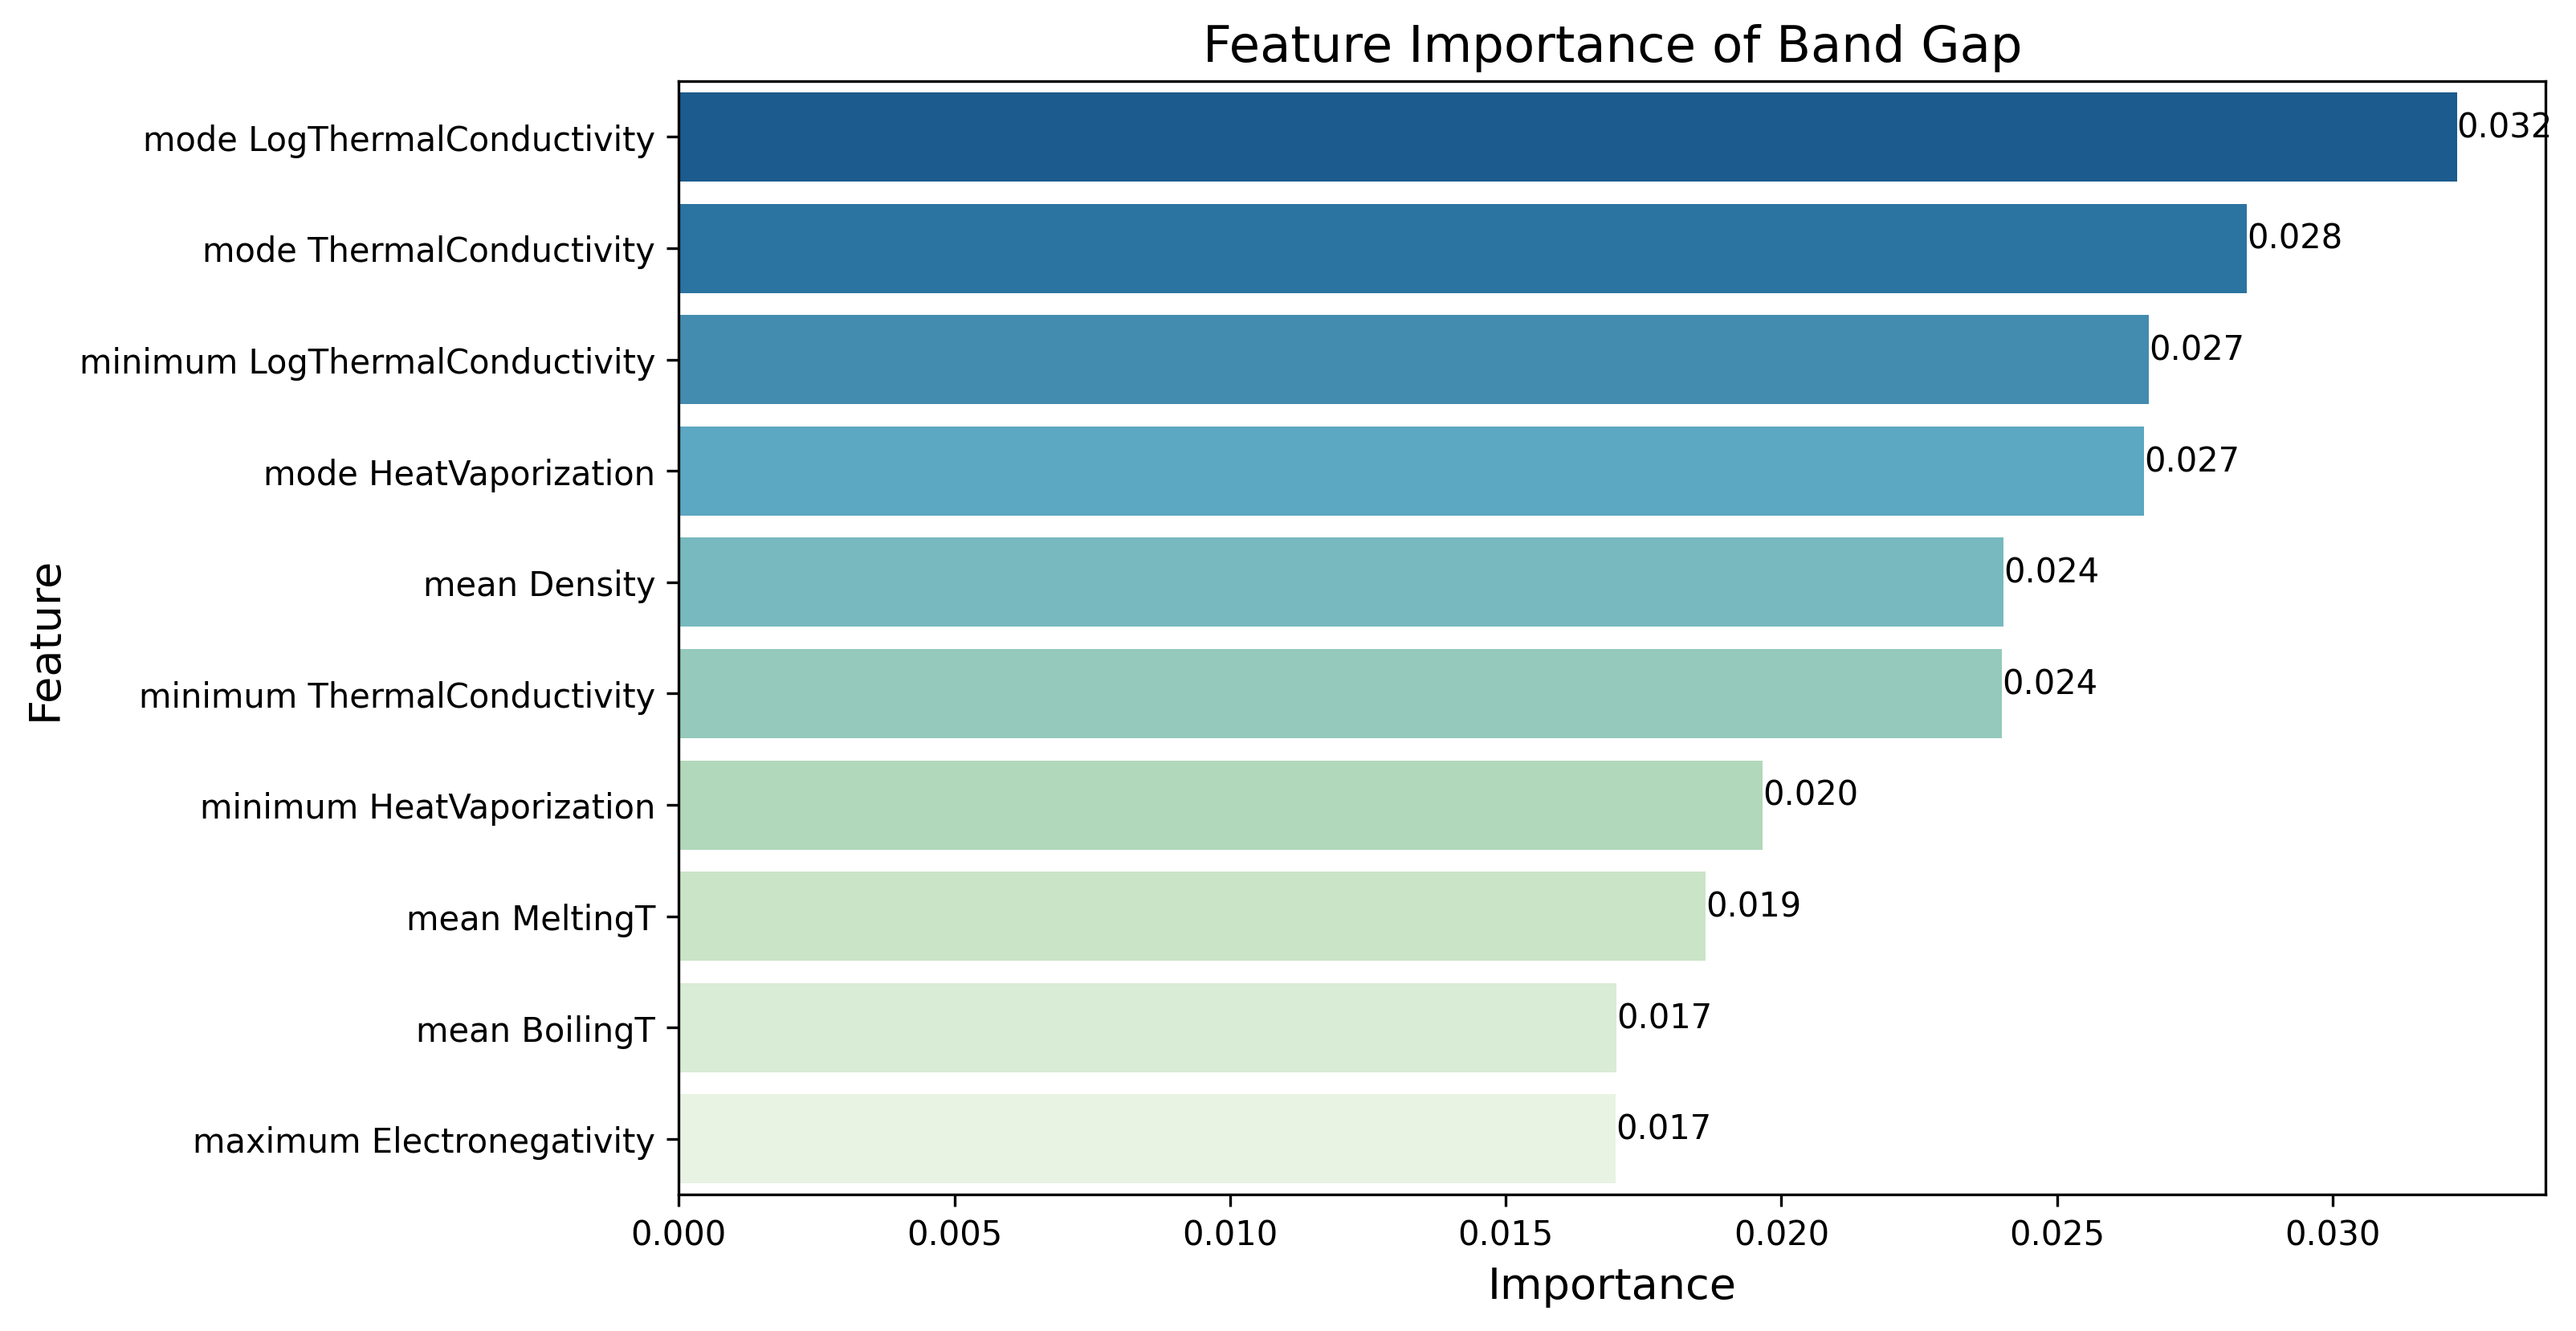

,Feature,Importance
0,mode LogThermalConductivity,0.032251
1,mode ThermalConductivity,0.028444
4,minimum LogThermalConductivity,0.026667
5,mode HeatVaporization,0.026581
2,mean Density,0.024024
3,minimum ThermalConductivity,0.024001
8,minimum HeatVaporization,0.019657
6,mean MeltingT,0.018624
7,mean BoilingT,0.017008
14,maximum Electronegativity,0.016990


In [47]:
# 绘制特征重要性图
from Utools.draw import plot_feature_importance
plot_feature_importance(estimator_final, X_train_best.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'feature_importance.png'))


In [48]:
feature_importance_df.head(10)

,Feature,Importance
0,mode LogThermalConductivity,0.032251
1,mode ThermalConductivity,0.028444
2,minimum LogThermalConductivity,0.026667
3,mode HeatVaporization,0.026581
4,mean Density,0.024024
5,minimum ThermalConductivity,0.024001
6,minimum HeatVaporization,0.019657
7,mean MeltingT,0.018624
8,mean BoilingT,0.017008
9,maximum Electronegativity,0.016990


In [49]:
selected_features[best_n_features - 1]

Index(['mode LogThermalConductivity', 'mode ThermalConductivity',
       'mean Density', 'minimum ThermalConductivity',
       'minimum LogThermalConductivity', 'mode HeatVaporization',
       'mean MeltingT', 'mean BoilingT', 'minimum HeatVaporization',
       'minimum MolarVolume',
       ...
       'minimum GSestFCClatcnt', 'mean DipolePolarizability',
       'minimum GSestBCClatcnt', 'range SpaceGroupNumber', 'range Number',
       'maximum BoilingT', 'range GSestBCClatcnt',
       'minimum FirstIonizationEnergy', 'maximum AtomicWeight',
       'maximum Number'],
      dtype='object', length=117)

In [55]:
# 保存RFE后的训练集和测试集
train_dir = os.path.join(current_path, 'Data', 'rfe_train_data')
test_dir = os.path.join(current_path, 'Data', 'rfe_test_data')  
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

drop_columns = dft_train.columns[~dft_train.columns.isin(list(best_features)+['composition', 'band_gap'])]
dft_train_rfe = dft_train.drop(columns=drop_columns)
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_test_set.csv'))
dft_test_rfe = dft_test.drop(columns=drop_columns)

# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'exp_test_set.csv'))
exp_train_rfe = exp_train.drop(columns=drop_columns)
exp_test_rfe = exp_test.drop(columns=drop_columns)
# mp plus data
mp_plus_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_plus_train_set.csv'))
mp_plus_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_plus_test_set.csv'))
mp_plus_train_rfe = mp_plus_train.drop(columns=drop_columns)
mp_plus_test_rfe = mp_plus_test.drop(columns=drop_columns)
# mix test 
mix_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mix_test_set.csv'))
mix_test_rfe = mix_test.drop(columns=drop_columns)


dft_train_rfe.to_csv(os.path.join(train_dir, 'mp_train_set.csv'), index=False)
dft_test_rfe.to_csv(os.path.join(test_dir, 'mp_test_set.csv'), index=False)
exp_train_rfe.to_csv(os.path.join(train_dir, 'exp_train_set.csv'), index=False) 
exp_test_rfe.to_csv(os.path.join(test_dir, 'exp_test_set.csv'), index=False)
mp_plus_train_rfe.to_csv(os.path.join(train_dir, 'mp_plus_train_set.csv'), index=False)
mp_plus_test_rfe.to_csv(os.path.join(test_dir, 'mp_plus_test_set.csv'), index=False)
mix_test_rfe.to_csv(os.path.join(test_dir, 'mix_test_set.csv'), index=False)


In [57]:
mp_plus_train_rfe.shape, mp_plus_test_rfe.shape

((7869, 130), (1963, 130))

In [58]:
dft_train_rfe.shape, dft_test_rfe.shape

((7869, 119), (1963, 119))

In [59]:
exp_train_rfe.shape, exp_test_rfe.shape

((2510, 119), (599, 119))

In [62]:
mix_test_rfe.shape

(1198, 119)